Fig. 5: Runtime performance comparison
----

In this notebook, we plot the runtime's of CellRank, Palantir, STEMNET and FateID. For CellRank, we
combine the time to compute the transition matrix and the time to compute the macrostates into one field by summing up these quantities.

# Preliminaries

## Dependency notebooks

1. [analysis_notebooks/MK_2020-10-16_gpcca.ipynb](analysis_notebooks/MK_2020-10-16_gpcca.ipynb)
2. [analysis_notebooks/MK_2020-10-16_palantir.ipynb](analysis_notebooks/MK_2020-10-16_palantir.ipynb)
3. [analysis_notebooks/MK_2020-10-16_stemnet.ipynb](analysis_notebooks/MK_2020-10-16_stemnet.ipynb)
4. [analysis_notebooks/MK_2020-10-16_fateid.r](analysis_notebooks/MK_2020-10-16_fateid.r)

## Import Packages

In [1]:
# import standard packages
from pathlib import Path
from collections import defaultdict
import os
import sys
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Set up paths

In [2]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

## Set global parameters

In [3]:
root = DATA_DIR / "benchmarking" / "runtime_analysis"
alg = "algorithm"

fns_ = {'gpcca': ['vg_time', 'k_time', 'dec_time', 'meta_time', 'ap_time'],
        'palantir': ['core_ts', 'core_no_ts'],
        'stemnet': ['stem_time']}

pretty_names = {
    'stem_time': 'STEMNET',
    'vg_time': 'velocity graph',  # not plotted
    'k_time': 'kernel',  # added to meta_time
    'dec_time': 'Schur decomposition',  # not plotted
    'meta_time': 'CellRank (macrostates)',
    'ap_time': 'CellRank (lin. probs.)',
    'core_ts': 'Palantir',
    'core_no_ts': 'Palantir',  # not ploted
}

save_figure = True

## Load the data

In [4]:
pickles = {f[:-7]:pickle.load(open(root / f, 'rb')) for f in os.listdir(root) if f.endswith(".pickle")}
csvs = {f[:-4]:pd.read_csv(root / f, index_col=0) for f in os.listdir(root) if f.endswith(".csv")}

### Add the kernel time to the macrostates time

In [5]:
for size, vs in pickles['gpcca'].items():
    for split, val in vs.items():
        pickles['gpcca'][size][split]['meta_time'] += pickles['gpcca'][size][split]['k_time']

### Create a joint object used for plotting

In [6]:
res = {}
for k, d in pickles.items():
    fns = fns_[k]
    dataframes = defaultdict(list)
    for size, val in d.items():
        tmp = pd.DataFrame(val).T
        for fn in fns:
            dataframes[fn].append(tmp[fn].T)
    for fn in fns:
        dataframes[fn] = pd.concat(dataframes[fn], axis=1)
        dataframes[fn].columns = d.keys()        
        dataframes[fn][alg] = pretty_names[fn]
    res[k] = dataframes
    
csvs['fateid'].columns = [int(c) if c != alg else c for c in csvs['fateid'].columns]
res['fateid'] = {'fate_bias': csvs['fateid']}

## Define utility functions

In [7]:
def plot(data, methods=dict(gpcca=('meta_time', 'ap_time'),
                            palantir='core_ts',
                            stemnet='stem_time',
                            fateid='fate_bias')):
    tmp = []
    aggregates = {}
    
    for k, d in data.items():
        if isinstance(methods[k], (tuple, list)):
            for k in methods[k]:
                tmp.append(d[k])
                vals = d[k].values[:, :-1].astype(np.float64)
                aggregates[d[k][alg].iloc[0]] = {'mean': np.nanmean(vals, axis=0), 'std': np.nanstd(vals, axis=0)}
        else:
            k = methods[k]
            tmp.append(d[k])
            vals = d[k].values[:, :-1].astype(np.float64)
            aggregates[d[k][alg].iloc[0]] = {'mean': np.nanmean(vals, axis=0), 'std': np.nanstd(vals, axis=0)}
            
    tmp = pd.concat(tmp, axis=0)
    tmp[alg] = tmp[alg].astype('category')
    tmp = pd.melt(tmp, id_vars=[alg], var_name='size', value_name='runtime')
    tmp = tmp[tmp['size'] != 104679]
    tmp["runtime"] = tmp["runtime"].astype(np.float64)
    
    fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
    colors = [sns.palettes.color_palette('colorblind')[i] for i in range(len(tmp[alg].cat.categories))]
    
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none', linestyle='none')
    
    sns.boxplot(x='size', y='runtime', hue=alg, data=tmp, ax=ax, width=0.25,
                saturation=1,
                dodge=False,
                flierprops=flierprops,
                linewidth=1,
                palette=colors)
        
    data = tmp.groupby(["algorithm", "size"]).median()
    for i, cat in enumerate(tmp[alg].cat.categories):
        med = data.loc[cat].values.squeeze()
        med = med[med == med]
        ax.plot(np.arange(len(med)), med, c=colors[i], zorder=-1, ls='--', lw=1.25)
        
    ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
    ax.set_title("comparison of runtimes")
    ax.set_xlabel('number of cells in thousands')
    #ax.set_xticklabels(np.linspace(10, 100, num=10, dtype='int'))
    ax.set_ylabel('runtime (s)')
    ax.margins(0.025)
    ax.set_yscale('log')
    
    fig.show()
    
    return fig, aggregates

# Plot the results

<ipython-input-7-143f5cfaf72c>:18: RuntimeWarning: Mean of empty slice
  aggregates[d[k][alg].iloc[0]] = {'mean': np.nanmean(vals, axis=0), 'std': np.nanstd(vals, axis=0)}
/home/marius.lange/miniconda3/envs/cellrank/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


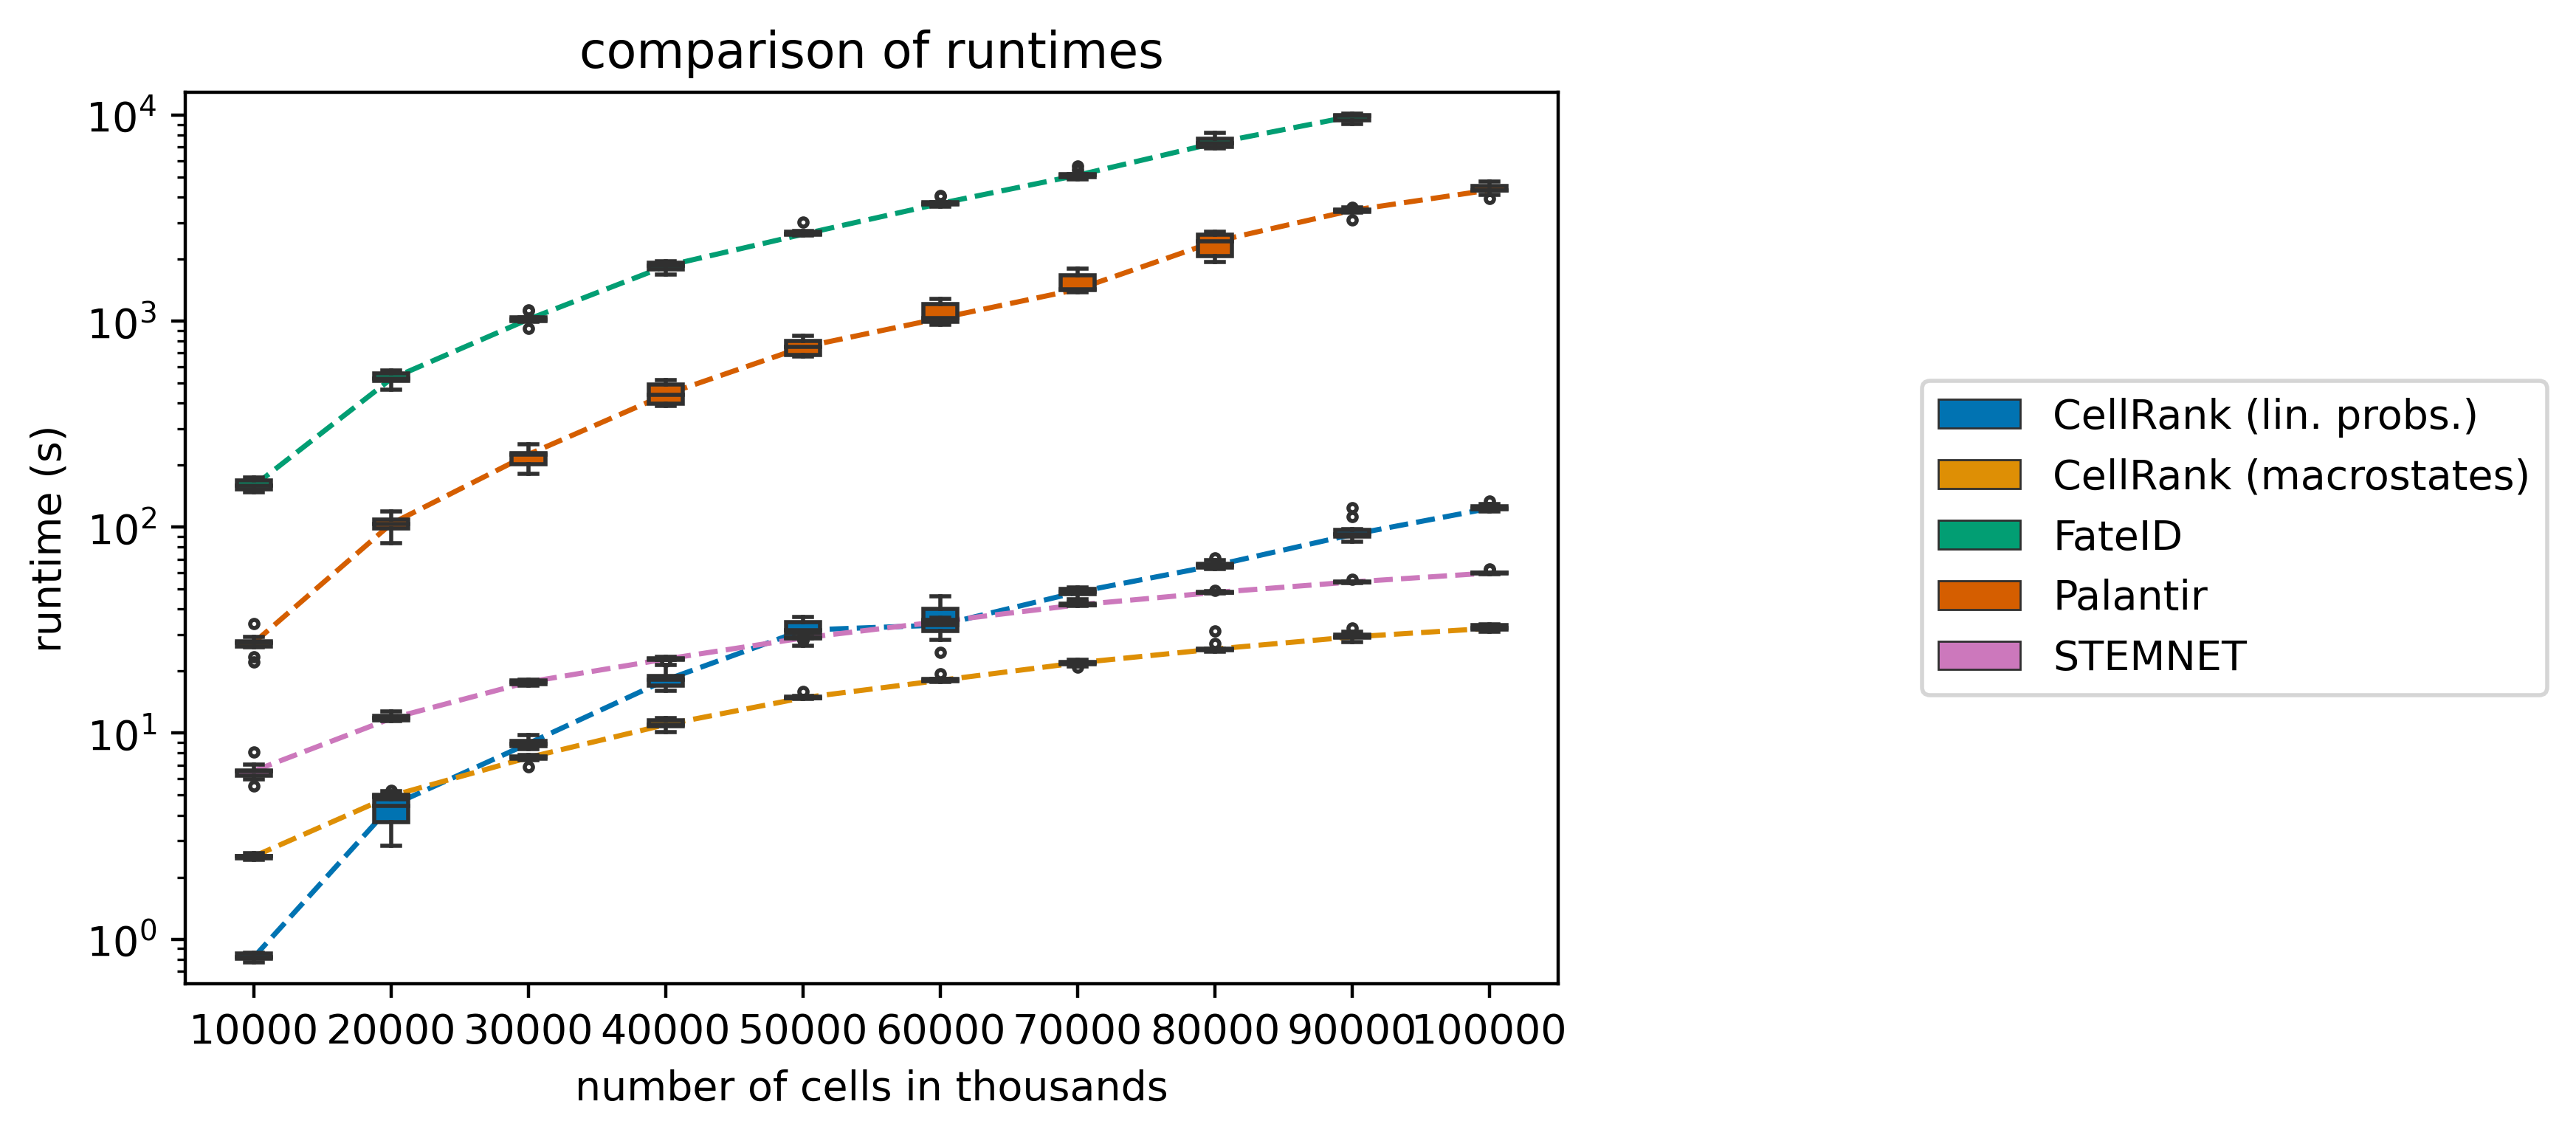

In [8]:
fig, agg = plot(res)
if save_figure:
    fig.savefig(FIG_DIR / "suppl_fig_time_benchmark" / "performance.pdf", bbox_inches='tight', transparent=True)

## Extract the data for the table creation

In [9]:
df = []
for algo, vals in agg.items():
    tmp = pd.DataFrame(vals)
    tmp.columns=[f'{algo} mean', f'{algo} std']
    tmp.index = [i * 10000 for i in range(1, 11)]
    tmp.index.name = "size"
    df.append(tmp)
df = pd.concat(df, axis=1)

# round 
df = df.round(1)

# make the index pretty
df.index = np.array(df.index/1000, dtype='int')
df.index.name = '#cells (thousands)'

In [10]:
df

,CellRank (macrostates) mean,CellRank (macrostates) std,CellRank (lin. probs.) mean,CellRank (lin. probs.) std,Palantir mean,Palantir std,STEMNET mean,STEMNET std,FateID mean,FateID std
#cells (thousands),,,,,,,,,,
10,2.8,0.9,1.5,2.2,27.3,3.0,6.5,0.3,160.5,8.8
20,5.0,0.1,4.2,0.8,102.5,10.4,11.9,0.4,531.1,31.7
30,7.6,0.1,8.8,0.8,217.6,19.8,17.7,0.4,1029.6,57.8
40,11.1,0.5,18.3,1.6,447.7,52.6,22.9,0.3,1840.8,89.5
50,15.0,0.3,32.1,2.9,750.1,66.1,28.9,0.3,2690.5,117.5
60,18.8,2.0,35.9,6.2,1092.4,119.5,35.0,0.6,3772.8,147.0
70,21.8,0.5,48.5,1.8,1524.1,158.9,42.1,0.5,5151.4,217.9
80,26.2,1.8,65.7,2.5,2352.1,292.4,48.4,0.5,7414.3,454.8
90,29.7,1.3,96.9,11.5,3424.8,130.4,54.3,0.6,9752.7,380.9


### Save the table

In [11]:
df.to_csv(DATA_DIR / "benchmarking_results" / "suppl_tab_time_benchmark" / "statistics.csv")